#  Neural Network for Customer Churn Prediction


In [58]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input
from sklearn.utils import class_weight



# Load and preprocess data


In [59]:
df = pd.read_csv('bank-customer-churn-prediction-challenge/train.csv')
df.drop([ 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Split features and target


In [60]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Handle missing values


In [61]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features


In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split


In [63]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [64]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

# Build neural network model


In [65]:
model =Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train model


In [66]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)
joblib.dump(model, 'model_ann.pkl')
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns, "feature_columns.pkl")

print("MLP model and preprocessors saved.")
print("Model saved as model_mlp.pkl")


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.7576 - loss: 0.5050 - val_accuracy: 0.8303 - val_loss: 0.4128
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.8162 - loss: 0.4036 - val_accuracy: 0.8600 - val_loss: 0.3358
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.8340 - loss: 0.3870 - val_accuracy: 0.8580 - val_loss: 0.3295
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.8542 - loss: 0.3533 - val_accuracy: 0.8577 - val_loss: 0.3440
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.8480 - loss: 0.3470 - val_accuracy: 0.8747 - val_loss: 0.3164
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.8571 - loss: 0.3404 - val_accuracy: 0.8767 - val_loss: 0.3160
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.8555 - loss: 0.3399 - val_accuracy: 0.8653 - val_loss: 0.3243
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.8509 - loss: 0.3396 - 

# Evaluate model


In [67]:
y_pred_proba = model.predict(X_val).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_val, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
Accuracy: 0.8790
F1 Score: 0.7394
ROC AUC: 0.9390
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      2413
         1.0       0.64      0.88      0.74       587

    accuracy                           0.88      3000
   macro avg       0.80      0.88      0.83      3000
weighted avg       0.90      0.88      0.89      3000



# Accuracy


# Load Test Data

In [68]:

test_df = pd.read_csv("bank-customer-churn-prediction-challenge/test.csv")

# Preprocess
X_test_raw = preprocess(test_df)

# Align columns with training set
feature_columns = joblib.load("feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)
# Apply imputer and scaler
imputer = joblib.load("imputer.pkl")
scaler = joblib.load("scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities
model = joblib.load("model_ann.pkl")
probas = model.predict(X_test_scaled).flatten()
# Build submission
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("submission_ann.csv", index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


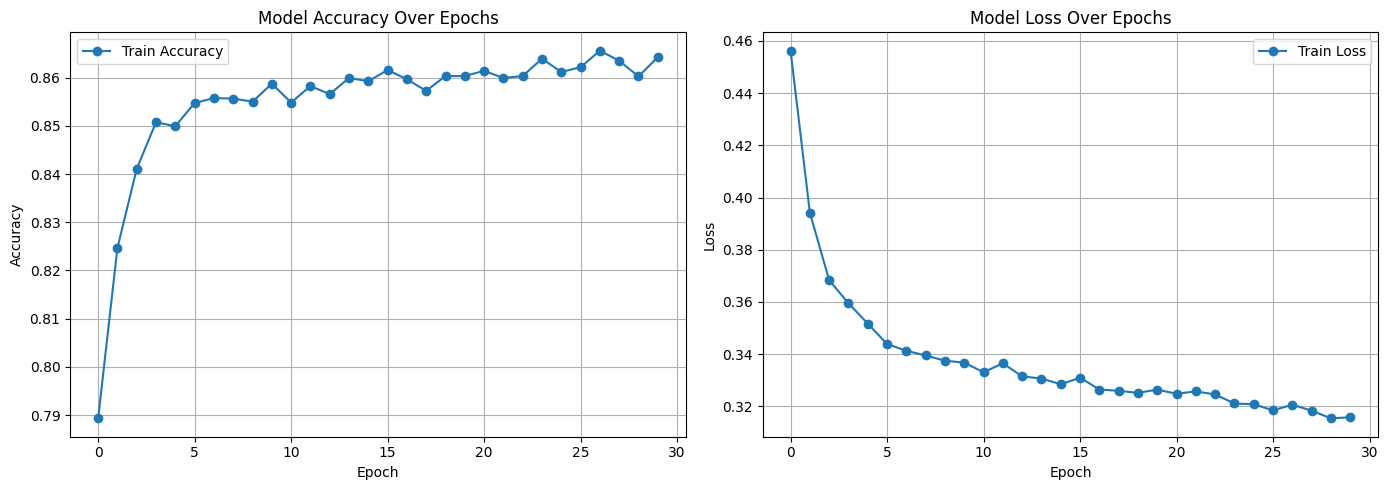

In [69]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

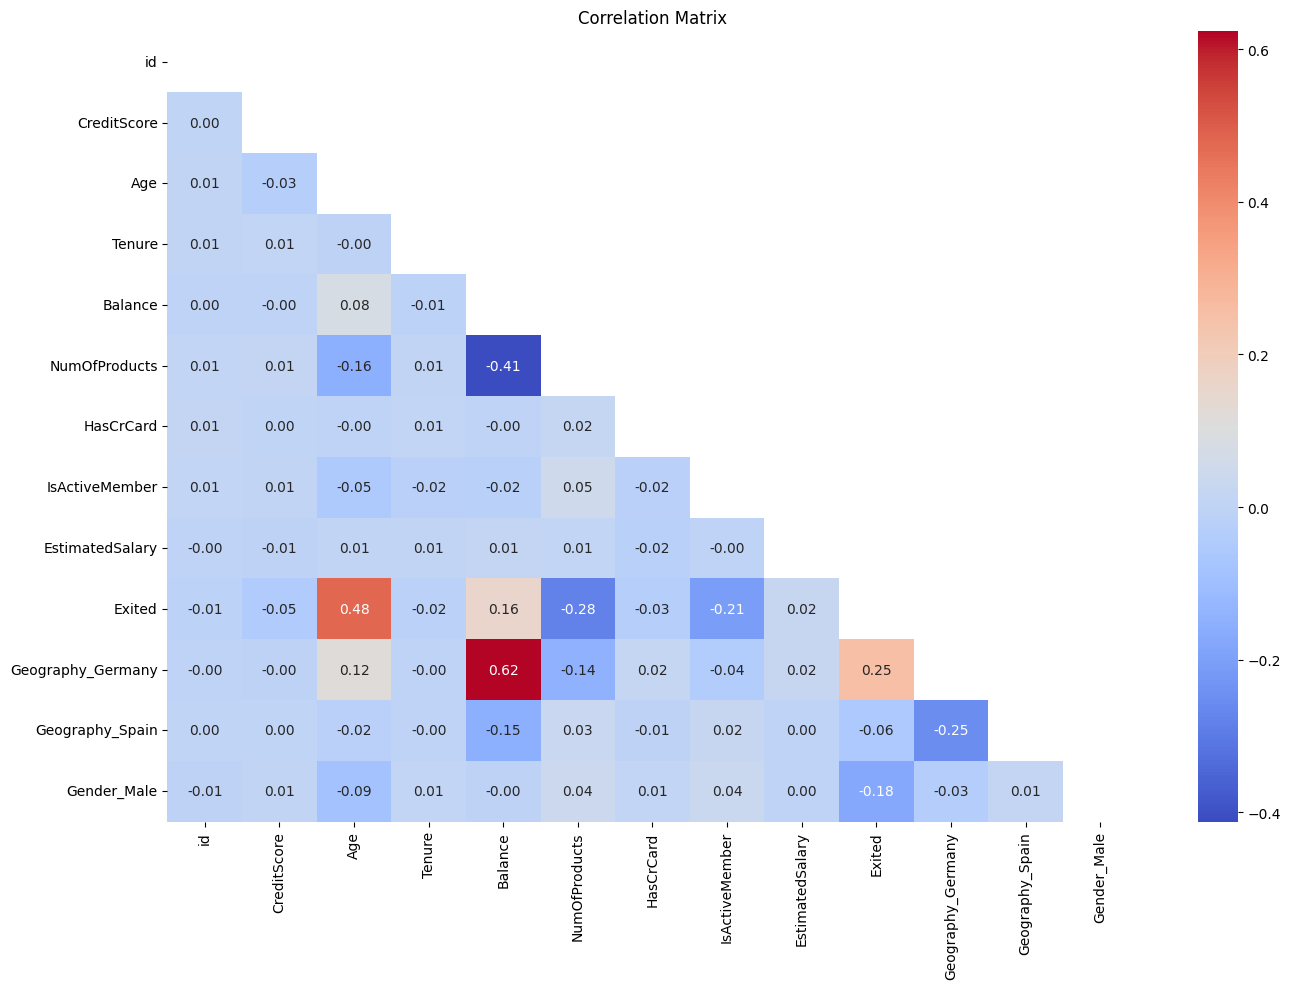

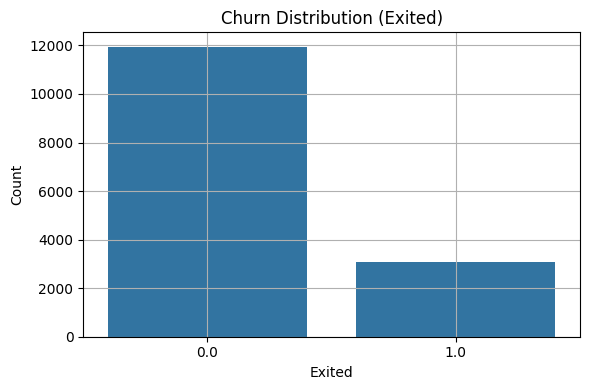

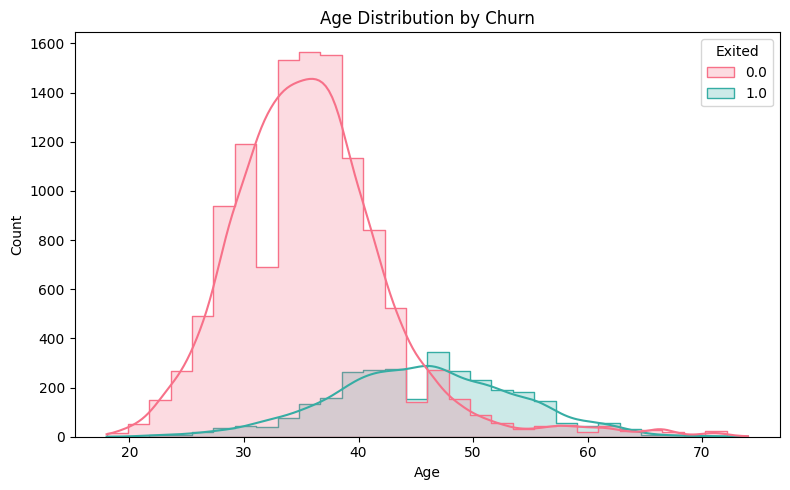

In [70]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Correlation Heatmap
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 2. Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution (Exited)")
plt.xlabel("Exited")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Age distribution by churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
